# Working through some stock market ML prediction examples 


Using Google Stock data from [Kaggle](https://www.kaggle.com/datasets/alirezajavid1999/google-stock-2010-2023) and supplemented from [MarketWatch](https://www.marketwatch.com/investing/stock/goog/download-data?startDate=8/1/2024&endDate=12/16/2024) (see Python code in the data directory)

## 1. scikit-learn and XGBoost

Working from this example : https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

Read in the data and calculate some features to use later

In [2]:
df = pd.read_csv('data/google.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

# the columns are recommended by the Geeks for Geeks example
df['is_quarter_end'] = np.where(df['month']%3==0,1,0) 
df['close-open']  = df['Close'] - df['Open']
df['high-low']  = df['High'] - df['Low']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0) # whether to buy or not
df

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,close-open,high-low,target
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,78169752,2010,1,4,0,-0.005005,0.131882,0
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,120067812,2010,1,5,0,-0.079830,0.157658,0
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,158988852,2010,1,6,0,-0.440440,0.487988,0
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,256315428,2010,1,7,0,-0.382883,0.434184,1
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,188783028,2010,1,8,0,0.250751,0.353854,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3758,2024-12-09,175.720000,178.040000,175.400000,177.100000,19887789,2024,12,9,1,1.380000,2.640000,1
3759,2024-12-10,184.540000,188.030000,182.670000,186.530000,34317441,2024,12,10,1,1.990000,5.360000,1
3760,2024-12-11,186.700000,196.890000,186.260000,196.710000,41664488,2024,12,11,1,10.010000,10.630000,0
3761,2024-12-12,196.300000,196.710000,193.280000,193.630000,25197760,2024,12,12,1,-2.670000,3.430000,0


In [3]:
df.describe()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,close-open,high-low,target
count,3763,3763.000000,3763.000000,3763.000000,3763.000000,3.763000e+03,3763.000000,3763.000000,3763.000000,3763.000000,3763.000000,3763.000000,3763.000000
mean,2017-06-23 22:07:06.680839680,61.148149,61.779111,60.534268,61.169949,5.558174e+07,2016.978209,6.528833,15.700771,0.334042,0.021800,1.244843,0.530428
min,2010-01-04 00:00:00,10.968719,11.068068,10.851602,10.912663,7.409106e+06,2010.000000,1.000000,1.000000,0.000000,-6.645004,0.076076,0.000000
25%,2013-09-28 12:00:00,22.652528,22.807807,22.487237,22.651777,2.663715e+07,2013.000000,4.000000,8.000000,0.000000,-0.246753,0.334918,0.000000
50%,2017-06-23 00:00:00,47.275002,47.525002,46.917999,47.275002,3.722400e+07,2017.000000,7.000000,16.000000,0.000000,0.008509,0.700701,1.000000
75%,2021-03-20 12:00:00,92.259998,93.876751,91.262753,92.270000,7.327665e+07,2021.000000,9.500000,23.000000,1.000000,0.309249,1.844006,1.000000
max,2024-12-13 00:00:00,196.300000,196.890000,193.280000,196.710000,5.923990e+08,2024.000000,12.000000,31.000000,1.000000,10.010000,10.630000,1.000000
std,NaN,46.586308,47.108606,46.106375,46.613001,4.794345e+07,4.309905,3.418514,8.749711,0.471717,1.070655,1.267601,0.499140


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3763 entries, 0 to 3762
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3763 non-null   datetime64[ns]
 1   Open            3763 non-null   float64       
 2   High            3763 non-null   float64       
 3   Low             3763 non-null   float64       
 4   Close           3763 non-null   float64       
 5   Volume          3763 non-null   int64         
 6   year            3763 non-null   int32         
 7   month           3763 non-null   int32         
 8   day             3763 non-null   int32         
 9   is_quarter_end  3763 non-null   int64         
 10  close-open      3763 non-null   float64       
 11  high-low        3763 non-null   float64       
 12  target          3763 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int32(3), int64(3)
memory usage: 338.2 KB


In [5]:
df.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
year              0
month             0
day               0
is_quarter_end    0
close-open        0
high-low          0
target            0
dtype: int64

<Axes: xlabel='Date', ylabel='Close'>

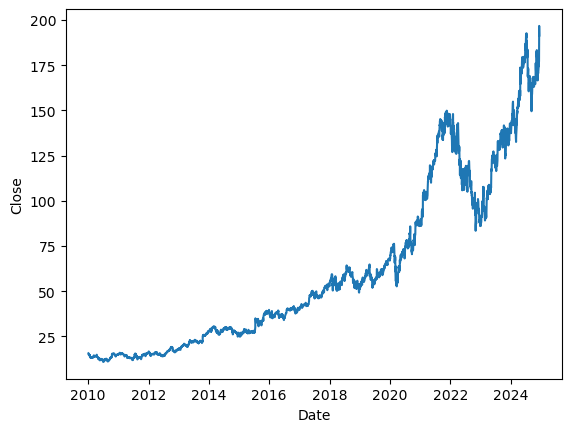

In [6]:
sns.lineplot(data = df, x = 'Date', y = 'Close')

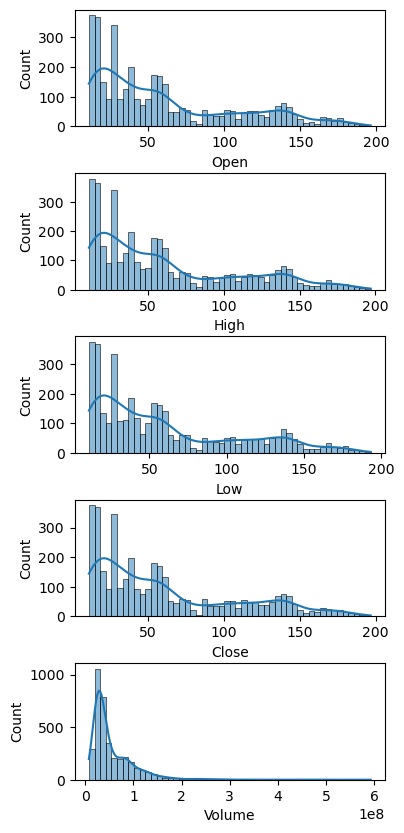

In [7]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

f, ax = plt.subplots(len(features), figsize=(4,10))
plt.subplots_adjust(hspace = 0.4)

for (axi,feat) in zip(ax,features):
    sns.histplot(data=df, x=feat, ax=axi, bins=50, kde=True)


<Axes: >

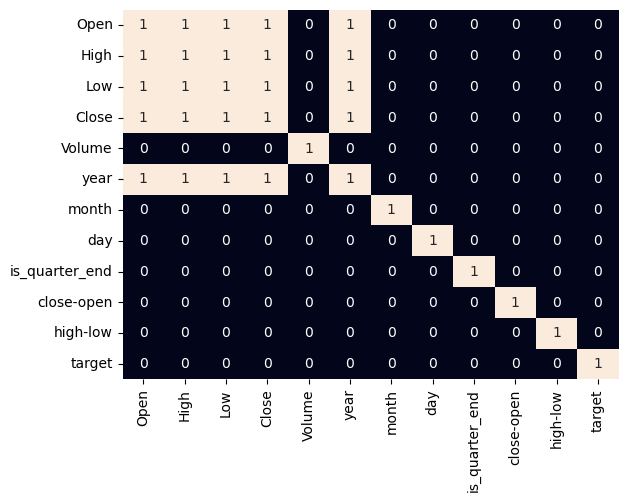

In [8]:
# check for correlations
#sns.heatmap(df.drop('Date', axis=1).corr(), annot=False, cbar=True)
sns.heatmap(df.drop('Date', axis=1).corr() > 0.9, annot=True, cbar=False) # only show the highly correlated values


Create and train a few models and check their performance

In [9]:
# try the model
features = df[['close-open', 'high-low', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler() # https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.1, random_state=1234)
print(X_train.shape, X_valid.shape)

(3386, 3) (377, 3)


In [10]:
# test a few models
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5065270709906596
Validation Accuracy :  0.4835380116959065

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.5071083311627126
Validation Accuracy :  0.5082163742690058

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 

None of these actually work well (though XGB has high training accuracy it does not have high validation accuracy)


## 2. TensorFlow and LSTM

Working from these examples : 
- https://www.geeksforgeeks.org/stock-price-prediction-project-using-tensorflow/
- https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

2024-12-17 10:30:20.721276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 10:30:20.746201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734453020.761883   16719 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734453020.766564   16719 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 10:30:20.798230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In this example, we train on a subset of data selected to be less than a certain date, and then try to predict the Close value for the remaining dates.

I also want to select some validation data.  Since this particular stock gets a bit volatile at the end, I will use the initial bits for validation.

In [12]:
# add a few more features?
df['7d_open_rolling_mean'] = df['Open'].rolling(7,min_periods=1).mean()
df['7d_high-low_rolling_mean'] = df['high-low'].rolling(7,min_periods=1).mean()
df

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,close-open,high-low,target,7d_open_rolling_mean,7d_high-low_rolling_mean
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,78169752,2010,1,4,0,-0.005005,0.131882,0,15.689439,0.131882
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,120067812,2010,1,5,0,-0.079830,0.157658,0,15.692317,0.144770
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,158988852,2010,1,6,0,-0.440440,0.487988,0,15.682265,0.259176
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,256315428,2010,1,7,0,-0.382883,0.434184,1,15.574262,0.302928
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,188783028,2010,1,8,0,0.250751,0.353854,0,15.422372,0.313113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3758,2024-12-09,175.720000,178.040000,175.400000,177.100000,19887789,2024,12,9,1,1.380000,2.640000,1,173.314286,2.938571
3759,2024-12-10,184.540000,188.030000,182.670000,186.530000,34317441,2024,12,10,1,1.990000,5.360000,1,175.382857,3.401429
3760,2024-12-11,186.700000,196.890000,186.260000,196.710000,41664488,2024,12,11,1,10.010000,10.630000,0,177.722857,4.444286
3761,2024-12-12,196.300000,196.710000,193.280000,193.630000,25197760,2024,12,12,1,-2.670000,3.430000,0,181.034286,4.675714


In [13]:
validate_cutoff_date = pd.to_datetime('1/1/2012')
training_cutoff_date = pd.to_datetime('1/1/2024')
idx_validate = df.loc[df['Date'] >= validate_cutoff_date].index[0]
idx_training = df.loc[df['Date'] >= training_cutoff_date].index[0]
print(idx_validate, idx_training)

504 3522


In [14]:
# put the predictor at the end
 
#features = ['Open', 'High', 'Low', 'Volume', 'Close'] 
features = ['Open', 'High', 'Low', 'close-open', 'high-low', 'is_quarter_end', '7d_open_rolling_mean', '7d_high-low_rolling_mean', 'Close'] 
#features = ['Open', 'High', 'Low', 'high-low', 'is_quarter_end', '7d_open_rolling_mean', 'Close'] 
#features = ['is_quarter_end', '7d_open_rolling_mean', '7d_high-low_rolling_mean', 'Close'] #

stock_data = df[features].to_numpy()

In [15]:

scaler = MinMaxScaler() 
scaled_stock_data = scaler.fit_transform(stock_data)

validating_stock = scaled_stock_data[0:idx_validate]
training_stock = scaled_stock_data[idx_validate:idx_training]
testing_stock = scaled_stock_data[idx_training:]

dates = df.filter(['Date']).values
validating_date = dates[0:idx_validate]
training_date = dates[idx_validate:idx_training]
testing_date = dates[idx_training:]


From here : https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571

> "...the training of an LSTM model requires a window or a timestep of data in each training step. For instance, the LSTM will take 10 data samples to predict the 10th one by weighing the first nine input samples in one step. So, we need a different approach than the train_test_split provided by scikit-learn.  Let’s define a splitting function called lstm_split() which will make windows of size "step_size" starting from the first sample of data and ending at step_size’th sample (if step_size=10, then the 10th sample) from the end.  We understand the latter part because, for each time step, LSTM will take step_size-1 samples for training and predict the last sample."

In [16]:
def lstm_split(data, step_size=10):
    x = []
    y = []
    for i in range(len(data) - step_size + 1):
        x.append(data[i:(i + step_size), :-1])
        y.append(data[i + step_size - 1, -1])

    return np.array(x), np.array(y)

In [17]:
step_size = 20
x_valid, y_valid = lstm_split(validating_stock, step_size)
x_train, y_train = lstm_split(training_stock, step_size)
x_test, y_test = lstm_split(testing_stock, step_size)
_, date_valid = lstm_split(validating_date, step_size)
_, date_train = lstm_split(training_date, step_size)
_, date_test = lstm_split(testing_date, step_size)

print(x_train.shape, y_train.shape)

(2999, 20, 8) (2999,)


In [18]:
# check
print(x_train[0][0] == training_stock[0][0:(len(features) - 1)])
print(y_train[0] == training_stock[step_size -1 ][len(features) - 1])

[ True  True  True  True  True  True  True  True]
True


Build a simple model (I need to look into all the options! -- Google Gemini had a good explanation [here](https://g.co/gemini/share/a85b742e5d32))

I suppose this is where the "art" comes in.  There are options for many layers, different types of optimization, additional parameters when fitting/training...

In [22]:
# Create the model
# model = Sequential([
#     Input(shape=(x_train.shape[1], 1)),
#     LSTM(64, return_sequences=True),
#     LSTM(64, return_sequences=True),
#     Dense(32),
#     Dropout(0.5),
#     Dense(1)
# ])

# trying an optimizer to improve training (and stop nans)
# At least my first attempt with these values seemed to dramatically improve the loss functions... mixed results after more playing
lr_schedule = CosineDecay(initial_learning_rate=1e-3, decay_steps=1e4)
optimizer = Adam(learning_rate=lr_schedule)
#optimizer = Adam()

model = Sequential([
    Input(shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=True),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# I think I may need to redefine the model above if I want to rerun this (otherwise it might build on the previous model?)
history = model.fit(
    x_train, y_train, 
    epochs=32,
    batch_size=16,
    verbose=2,
    shuffle=False,
    validation_data=(x_valid, y_valid)
)

Epoch 1/32
188/188 - 4s - 20ms/step - loss: 9.3294e-04 - val_loss: 0.0121
Epoch 2/32
188/188 - 3s - 14ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 3/32
188/188 - 3s - 14ms/step - loss: 0.0019 - val_loss: 0.0075
Epoch 4/32
188/188 - 2s - 12ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/32
188/188 - 3s - 13ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 6/32
188/188 - 2s - 12ms/step - loss: 0.0027 - val_loss: 6.3170e-04
Epoch 7/32
188/188 - 2s - 12ms/step - loss: 0.0018 - val_loss: 5.5087e-04
Epoch 8/32
188/188 - 2s - 12ms/step - loss: 0.0017 - val_loss: 7.9904e-04
Epoch 9/32
188/188 - 2s - 12ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 10/32
188/188 - 2s - 12ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/32
188/188 - 2s - 12ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 12/32
188/188 - 4s - 23ms/step - loss: 0.0029 - val_loss: 6.2824e-04
Epoch 13/32
188/188 - 2s - 12ms/step - loss: 0.0021 - val_loss: 3.3045e-04
Epoch 14/32
188/188 - 2s - 12ms/step - loss: 0.0011 - val_loss

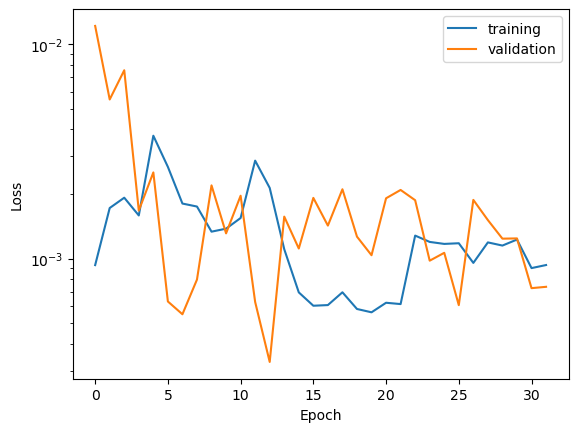

In [24]:
# plot the loss curve
f, ax = plt.subplots()
ax.plot(history.history['loss'], label = 'training')
ax.plot(history.history['val_loss'], label = 'validation')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()


In [25]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [26]:
# for the model with more layers
# prediction_train = y_train_pred.T.reshape(-1)
# prediction_test = y_test_pred.T.reshape(-1)


# for the model with less layers
# Extract the last predicted value from each sequence and reshape to match the expected target shape (X,)
prediction_train = y_train_pred[:, -1, :]  
prediction_train = prediction_train.reshape(-1) 

prediction_test = y_test_pred[:, -1, :]  
prediction_test = prediction_test.reshape(-1) 

In [27]:
# rescale back to the true values (requiring array reshaping)
#prediction = scaler.inverse_transform(np.array([prediction]).T).T


In [28]:
print(len(prediction_train), len(date_train))
print(len(prediction_test), len(date_test))

2999 2999
222 222


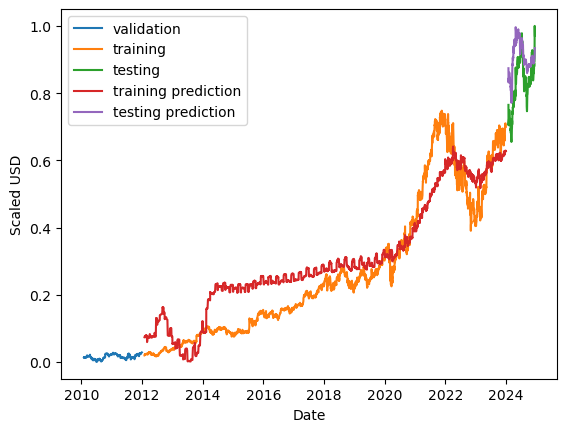

In [29]:
f,ax = plt.subplots()
ax.plot(date_valid, y_valid, label = 'validation')
ax.plot(date_train, y_train, label = 'training')
ax.plot(date_test, y_test, label = 'testing')
ax.plot(date_train, prediction_train, label='training prediction')
ax.plot(date_test, prediction_test, label='testing prediction')

ax.set_xlabel('Date')
ax.set_ylabel('Scaled USD')
ax.legend()